In [2]:
import os

file_path = os.path.abspath('Testing.ipynb')
file_dir = os.path.dirname(file_path)

print("File path:", file_path)
print("Directory:", file_dir)

File path: C:\Users\timlf\PycharmProjects\Semester_Project_Too\Testing.ipynb
Directory: C:\Users\timlf\PycharmProjects\Semester_Project_Too


In [5]:
import pyautogui
pyautogui.click(2000, 600)
pyautogui.write(f"python /home/ipa/quanz/user_accounts/tfessler/software/pyRetLIFE/scripts/create_spectrum.py --config ~/config_files/VH2O_create_spectrum.yaml")
# pyautogui.press('enter')


In [21]:
import os
print("Exists:", os.path.exists("config_files"))
print("Is dir:", os.path.isdir("config_files"))
print("Is file:", os.path.isfile("config_files"))

Exists: True
Is dir: True
Is file: False


In [22]:
open("config_files/test.txt", "w").close()

In [27]:
import os
from fabric import Connection

c = Connection('tfessler@rainbow', connect_kwargs={"password": "Dl2oP1AjOjO6"})

local_dir = "config_files"
remote_dir = "/home/tfessler/config_files"

# Ensure remote directory exists
c.run(f"mkdir -p {remote_dir}")

# Upload each file
for file in os.listdir(local_dir):
    local_path = os.path.join(local_dir, file)
    if os.path.isfile(local_path):
        c.put(local_path, remote=f"{remote_dir}/{file}")
        print(f"Uploaded {file}")

Uploaded spectrumVH2O_M=0.6.yaml
Uploaded spectrumVH2O_M=0.8.yaml
Uploaded spectrumVH2O_M=1.2.yaml
Uploaded spectrumVH2O_M=1.4.yaml
Uploaded spectrumVH2O_M=1.6.yaml
Uploaded spectrumVH2O_M=1.8.yaml
Uploaded spectrumVH2O_M=1.yaml
Uploaded spectrumVH2O_M=2.yaml


In [30]:
os.makedirs("config_files_M", exist_ok=True)

FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'config_files_M'

In [1]:
import lifesimmc
print(lifesimmc.__version__)

1.0.15


In [78]:
import numpy as np
from matplotlib import pyplot as plt
from phringe.core.entities.scene import Scene
from phringe.core.entities.sources.exozodi import Exozodi
from phringe.core.entities.sources.local_zodi import LocalZodi
from phringe.core.entities.sources.planet import Planet
from phringe.core.entities.sources.star import Star
from scipy.stats import ncx2, norm

from lifesimmc.core.modules.generating.data_generation_module import DataGenerationModule
from lifesimmc.core.modules.generating.template_generation_module import TemplateGenerationModule
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.modules.processing.correlation_map_module import CorrelationMapModule
from lifesimmc.core.modules.processing.energy_detector_test_module import EnergyDetectorTestModule
from lifesimmc.core.modules.processing.ml_parameter_estimation_module import MLParameterEstimationModule
from lifesimmc.core.modules.processing.neyman_pearson_test_module import NeymanPearsonTestModule
from lifesimmc.core.modules.processing.variance_normalization_module import NoiseVarianceNormalizationModule
from lifesimmc.core.pipeline import Pipeline
from lifesimmc.lib.colormaps import cmap_blue
from lifesimmc.lib.instrument import LIFEReferenceDesign, InstrumentalNoise
from lifesimmc.lib.observation import LIFEReferenceObservation

In [139]:
# Use the predefined ideal LIFE baseline instrument, i.e. without any instrumental noise
inst = LIFEReferenceDesign(instrumental_noise=InstrumentalNoise.NONE)

# For this example, manually update the spectral resolving power and aperture diameter
inst.spectral_resolving_power = 120
inst.aperture_diameter = 8

# User the predefined observation for the LIFE baseline design
obs = LIFEReferenceObservation(
    total_integration_time='10 d',
    detector_integration_time='0.05 d',  # should be chosen small enough to sufficiently sample the planet signal
    optimized_star_separation='habitable-zone'
)

In [140]:
scene = Scene()

sun_twin = Star(
    name='Sun Twin',
    distance='10 pc',
    mass='1 Msun',
    radius='1 Rsun',
    temperature='5700 K',
    right_ascension='10 hourangle',
    declination='45 deg',
)

local_zodi = LocalZodi()

exozodi = Exozodi(level=3)

earth_twin = Planet(
    name='Earth Twin',
    has_orbital_motion=False,
    mass='1 Mearth',
    radius='1 Rearth',
    temperature='254 K',
    semi_major_axis='1 au',
    eccentricity='0',
    inclination='0 deg',
    raan='90 deg',
    argument_of_periapsis='0 deg',
    true_anomaly='45 deg',
    input_spectrum=None,
)

scene.add_source(sun_twin)
scene.add_source(local_zodi)
scene.add_source(exozodi)
scene.add_source(earth_twin)

In [141]:
# Create the pipeline
pipeline = Pipeline(gpu_index=2, seed=42, grid_size=40)

# Setup the simulation
module = SetupModule(
    n_setup_out='setup',
    n_planet_params_out='params_init',
    instrument=inst,
    observation=obs,
    scene=scene
)
pipeline.add_module(module)

In [142]:
module = DataGenerationModule(n_setup_in='setup', n_data_out='data')
pipeline.add_module(module)

In [143]:
module = TemplateGenerationModule(n_setup_in='setup', n_template_out='temp', fov=1e-6)
pipeline.add_module(module)

In [144]:
module = NoiseVarianceNormalizationModule(
    n_setup_in='setup',
    n_data_in='data',
    n_template_in='temp',  # Optional
    n_planet_params_in='params_init',
    n_data_out='data_norm',
    n_template_out='temp_norm',  # Optional
    n_transformation_out='norm',
)
pipeline.add_module(module)

Loading configuration...
Done
Generating synthetic data...
Done
Generating templates...
Done
Normalizing with noise variance...
Done
Calculating correlation map...
Done


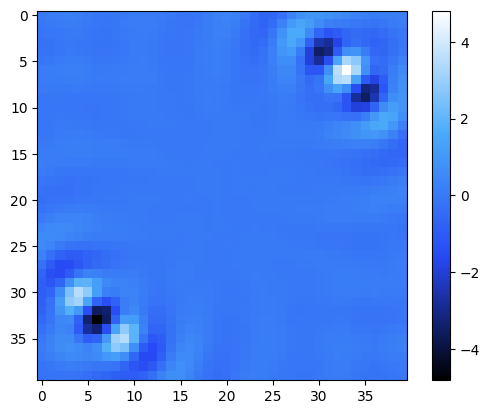

In [145]:
# Generate the correlation map
module = CorrelationMapModule(n_data_in='data_norm', n_template_in='temp_norm', n_image_out='imag_corr')
pipeline.add_module(module)

# Run pipeline with all modules we have added so far
pipeline.run()

# Get the correlation map from the image resource
imag_corr = pipeline.get_resource('imag_corr').get_image(as_numpy=True)

# Plot the image
plt.imshow(imag_corr, cmap=cmap_blue)
plt.colorbar()
plt.show()

In [146]:
module = MLParameterEstimationModule(
    n_setup_in='setup',
    n_data_in='data_norm',
    n_template_in='temp_norm',
    n_transformation_in='norm',
    n_planet_params_in='params_init',
    n_planet_params_out='params_ml',
)
pipeline.add_module(module)
pipeline.run()

Performing numerical MLE...
Done


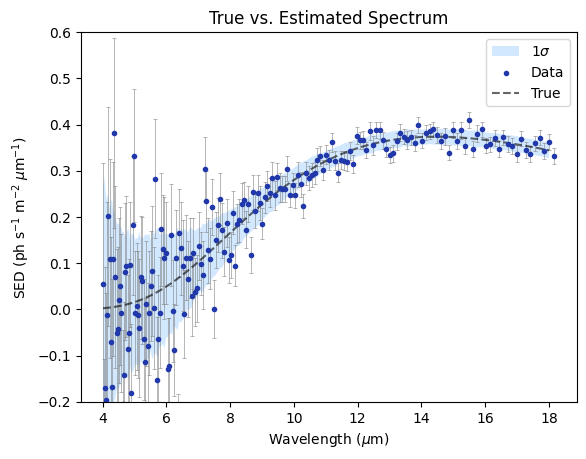

In [147]:
# Get the initial (input) parameters so we can plot the input spectrum (spectral energy distribution; SED) as a reference
params_init = pipeline.get_resource('params_init')
sed_init = params_init.params[0].sed.cpu().numpy()[:-1]  # Convert to numpy array from a torch Tensor
sed_init /= 1e6  # Convert to ph s-1 m-2 um-1
wavelengths = params_init.params[0].sed_wavelength_bin_centers.cpu().numpy()  # Convert to Torch tensor
wavelengths *= 1e6  # Convert from m to um

# Get the estimated parameters
params_ml = pipeline.get_resource('params_ml')
sed_estimated = params_ml.params[0].sed.cpu().numpy()
sed_estimated /= 1e6  # Convert to ph s-1 m-2 um-1
sed_err_low = params_ml.params[0].sed_err_low / 1e6
sed_err_high = params_ml.params[0].sed_err_high / 1e6

# Plot everything
yerr = np.stack([sed_err_low, sed_err_high])
plt.errorbar(
    wavelengths,
    sed_estimated,
    yerr=yerr,
    fmt='none',
    ecolor='gray',
    alpha=0.8,
    zorder=1,
    capsize=1.5,
    capthick=0.5,
    linewidth=0.5
)
plt.fill_between(
    wavelengths[:-1],
    np.array(sed_init) - np.array(sed_err_low)[:-1],
    np.array(sed_init) + np.array(sed_err_high)[:-1],
    color='dodgerblue',
    edgecolor=None,
    lw=0,
    alpha=0.2,
    label='1$\sigma$',
    zorder=0
)
plt.scatter(wavelengths, sed_estimated, label='Data', color="xkcd:sapphire", zorder=2, marker='.')
plt.plot(wavelengths[:-1], sed_init, label='True', linestyle='dashed', color='black', alpha=0.6, zorder=1)
plt.title('True vs. Estimated Spectrum')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SED (ph s$^{-1}$ m$^{-2}$ $\mu$m$^{-1}$)')
plt.ylim(-0.2, 0.6)
plt.legend()
plt.savefig('Test_spectrum.png')
plt.show()

In [158]:
# Physical constants
h = 6.62607015e-34  # Planck constant (J·s)
c = 2.99792458e8    # Speed of light (m/s)
erg_per_J = 1e7     # 1 J = 1e7 erg

def convert_flux(
    wavelength_micron,
    F_lambda_ph=None,
    F_lambda_erg=None,
    err_low=None,
    err_high=None
):
    """
    Convert between photon flux, energy flux per wavelength, and per frequency.
    Optionally also transforms asymmetric errors.
    """
    λ = np.array(wavelength_micron) * 1e-6  # µm → m

    if F_lambda_ph is not None:
        F_lambda_J = np.array(F_lambda_ph) * (h * c / λ)
        F_lambda_erg = F_lambda_J * erg_per_J
        if err_low is not None and err_high is not None:
            err_low_erg  = np.array(err_low)  * (h * c / λ) * erg_per_J
            err_high_erg = np.array(err_high) * (h * c / λ) * erg_per_J
    elif F_lambda_erg is not None:
        F_lambda_J = np.array(F_lambda_erg) / erg_per_J
        F_lambda_ph = F_lambda_J / (h * c / λ)
        if err_low is not None and err_high is not None:
            err_low_ph  = np.array(err_low)  / ((h * c / λ) * erg_per_J)
            err_high_ph = np.array(err_high) / ((h * c / λ) * erg_per_J)
    else:
        raise ValueError("Provide either F_lambda_ph or F_lambda_erg")

    # Convert to per Hz
    F_lambda_SI = F_lambda_J * 1e6  # µm⁻¹ → m⁻¹
    F_nu_J = F_lambda_SI * λ**2 / c
    F_nu = F_nu_J * erg_per_J
    if err_low is not None and err_high is not None:
        err_low_nu  = np.array(err_low)  * (λ**2 / c)
        err_high_nu = np.array(err_high) * (λ**2 / c)

    result = {
        "F_lambda_erg": F_lambda_erg,
        "F_lambda_ph": F_lambda_ph,
        "F_nu": F_nu,
    }

    if err_low is not None and err_high is not None:
        result.update({
            "err_low_erg":  locals().get("err_low_erg", None),
            "err_high_erg": locals().get("err_high_erg", None),
            "err_low_nu":   locals().get("err_low_nu", None),
            "err_high_nu":  locals().get("err_high_nu", None),
        })

    return result

result = convert_flux(wavelengths, F_lambda_ph=sed_estimated, err_low=sed_err_low, err_high=sed_err_high)
print(result['F_nu'])
print((result['err_low_nu']+result['err_high_nu'])/2)

[ 1.45513907e-27 -1.05625309e-26 -4.63532997e-27 -5.37395062e-27
 -3.43998951e-28  5.57532343e-27  3.07743487e-27 -1.98355802e-27
 -4.76876257e-27  3.14398437e-27  1.10512262e-26  2.04497229e-27
 -1.51394168e-27 -1.28398990e-27  5.78650094e-28  1.52576103e-27
 -2.47007113e-28 -6.25723566e-27 -4.38466597e-27  2.53597481e-27
  2.92741201e-27 -2.74799356e-27 -1.62936129e-27  3.11010915e-27
 -5.89806646e-27  5.96013262e-27  1.10040768e-26 -2.39320072e-28
  2.15405235e-28 -3.86583051e-28 -1.36287466e-27  2.37625232e-27
  2.16783727e-27 -2.28326300e-27 -4.05158422e-27  4.30086445e-28
 -2.81571351e-27 -2.71076748e-28  1.85594419e-27  3.08835198e-27
  1.45022751e-28  1.05972253e-26 -5.79840418e-27 -2.45686943e-27
 -2.66757596e-28  6.70024568e-27  5.06394742e-27  4.37291358e-27
  4.83639561e-27 -5.19449987e-27 -4.99485440e-27  6.53701841e-27
 -1.83782308e-28 -3.60619958e-27  4.67755238e-27 -1.24496561e-26
  7.02235903e-27  5.65356791e-27  4.08978524e-27 -4.56269892e-28
  4.90911836e-27  2.90830

<ErrorbarContainer object of 3 artists>

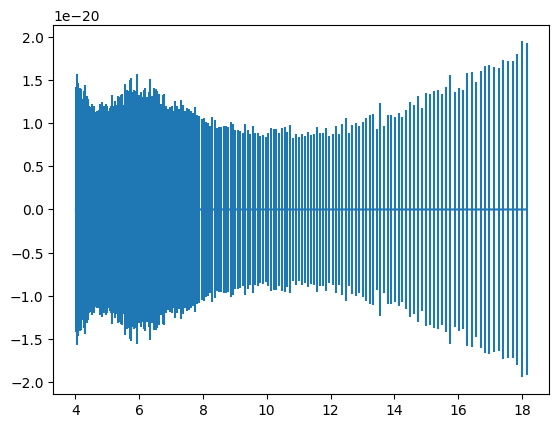

In [153]:
plt.errorbar(wavelengths, result['F_nu'], yerr=(result['err_low_nu']+result['err_high_nu'])/2)

In [41]:
# data = np.column_stack((wavelengths, sed_estimated, yerr))
# np.savetxt("sed_data.txt", data, header="wavelengths sed_estimated yerr", fmt="%.6e")

print(wavelengths)
print(sed_estimated)
print(yerr)

[ 4.0201     4.0605035  4.1013126  4.142532   4.1841655  4.2262173
  4.2686915  4.3115935  4.3549256  4.398694   4.442902   4.487554
  4.5326552  4.5782094  4.624222   4.6706963  4.717638   4.7650514
  4.8129416  4.8613124  4.91017    4.9595184  5.0093627  5.059708
  5.1105595  5.161922   5.213801   5.266201   5.319127   5.372586
  5.4265814  5.48112    5.5362067  5.5918474  5.6480465  5.704811
  5.7621455  5.820057   5.8785496  5.9376307  5.9973054  6.0575795
  6.1184597  6.179952   6.2420616  6.304796   6.3681607  6.432163
  6.4968076  6.562102   6.6280527  6.6946664  6.7619495  6.829909
  6.898551   6.967883   7.0379124  7.108645   7.1800885  7.25225
  7.325137   7.3987565  7.473116   7.548223   7.6240845  7.700708
  7.7781024  7.856274   7.935232   8.014983   8.095535   8.176898
  8.259078   8.342084   8.425923   8.510606   8.59614    8.682533
  8.769794   8.857934   8.946958   9.036877   9.1277     9.219436
  9.312094   9.405683   9.500212   9.595691   9.69213    9.789538
  9.8879

In [12]:
module = EnergyDetectorTestModule(
    n_setup_in="setup",
    n_data_in='data_norm',
    n_transformation_in='norm',
    n_planet_params_in='params_init',
    n_test_out='test_ed',
    pfa=0.00135  # Corresponds to a 3 sigma detection threshold
)
pipeline.add_module(module)
pipeline.run()

Performing energy detector test...
Done


In [14]:
# Get resource and extract parameters
test_ed = pipeline.get_resource('test_ed')
pfa = test_ed.probability_false_alarm
p_value = test_ed.p_value

# Print detection result
if p_value <= pfa:
    print(f'Detected (p-value: {np.round(p_value, 7)})')
else:
    print(f'Not detected (p-value: {np.round(p_value, 7)})')

Detected (p-value: 3.44e-05)


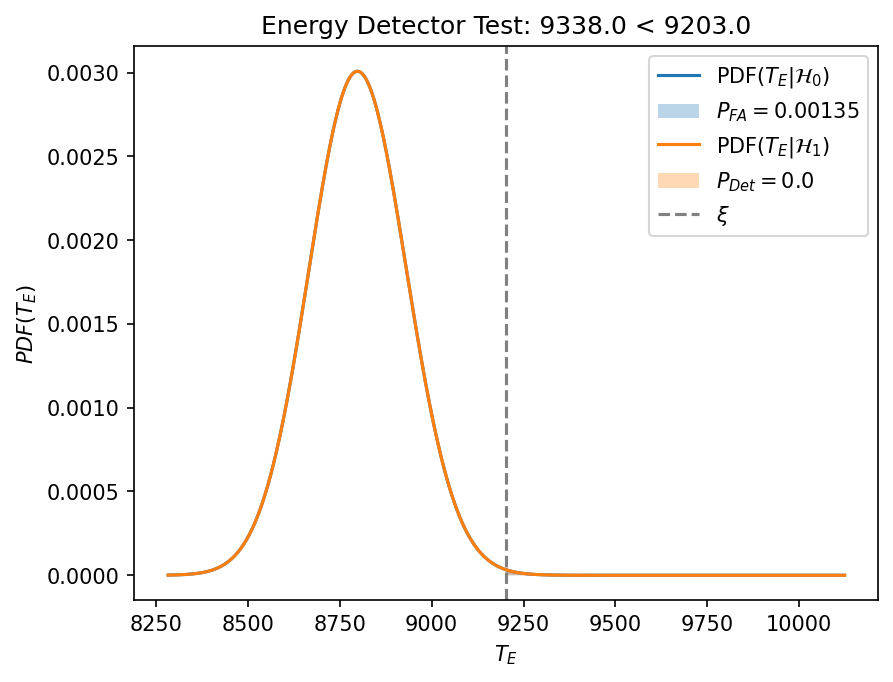

In [17]:
# Extract parameters
test_h1 = test_ed.test_statistic_h1
test_h0 = test_ed.test_statistic_h0
xsi = test_ed.threshold_xsi
xtx = test_ed.model_length_xtx
ndim = test_ed.dimensions
pdet = test_ed.detection_probability

# Plot distributions
z = np.linspace(0.9 * xsi, 1.1 * xsi, 1000)
zdet = z[z > xsi]
zndet = z[z < xsi]
fig = plt.figure(dpi=150)
plt.title(f'Energy Detector Test: {np.round(test_h1, 0)} < {np.round(xsi, 0)}')
plt.plot(z, ncx2.pdf(z, df=ndim, nc=0), label=f"PDF($T_{{E}} | \mathcal{{H}}_0$)")
plt.fill_between(zdet, ncx2.pdf(zdet, df=ndim, nc=0), alpha=0.3, label=f"$P_{{FA}}={pfa}$")
plt.plot(z, ncx2.pdf(z, df=ndim, nc=xtx), label=f"PDF($T_{{E}}| \mathcal{{H}}_1$)")
plt.fill_between(zdet, ncx2.pdf(zdet, df=ndim, nc=xtx), alpha=0.3, label=f"$P_{{Det}}={np.round(pdet, 2)}$")
plt.axvline(xsi, color="gray", linestyle="--", label=f"$\\xi$")
plt.xlabel(f"$T_{{E}}$")
plt.ylabel(f"$PDF(T_{{E}})$")
plt.legend()
plt.show()

Performing Neyman-Pearson test...
Done
Not detected (p-value: 0.5245)


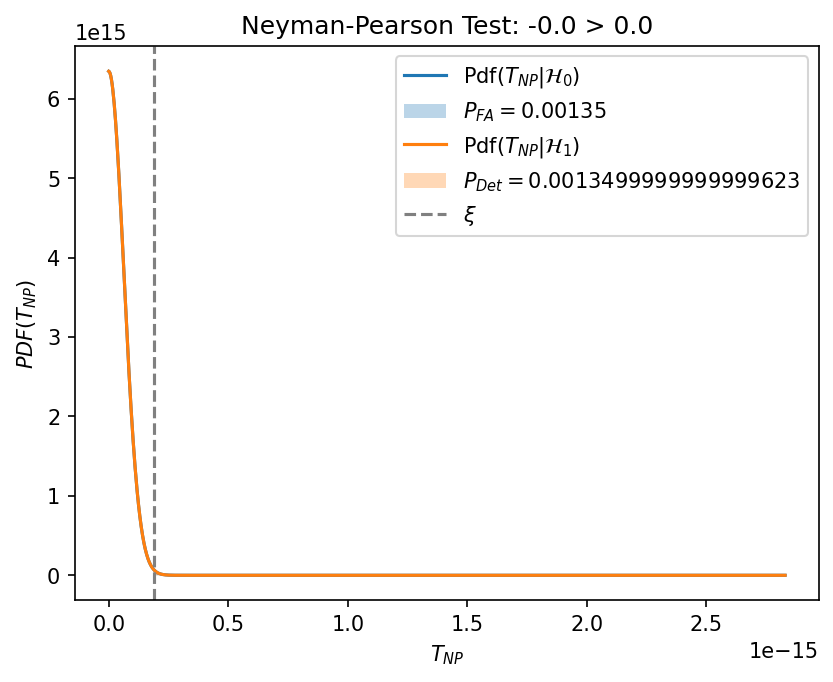

In [18]:
# Add module and run pipeline
module = NeymanPearsonTestModule(
    n_setup_in="setup",
    n_data_in='data_norm',
    n_transformation_in='norm',
    n_planet_params_in='params_init',
    n_test_out='test_np',
    n_image_out='imag_np',
    pfa=0.00135  # Corresponds to a 3 sigma detection threshold
)
pipeline.add_module(module)
pipeline.run()

# Extract parameters from resource
test_np = pipeline.get_resource('test_np')
test_h1 = test_np.test_statistic_h1
test_h0 = test_np.test_statistic_h0
xsi = test_np.threshold_xsi
xtx = test_np.model_length_xtx
ndim = test_np.dimensions
pdet = test_np.detection_probability
pfa = test_np.probability_false_alarm
p_value = test_np.p_value

# Print detection result
if p_value <= pfa:
    print(f'Detected (p-value: {np.round(p_value, 4)})')
else:
    print(f'Not detected (p-value: {np.round(p_value, 4)})')

# Plot distributions
z = np.linspace(-0.5 * xtx, 15 * xsi, 1000)
zdet = z[z > xsi]
zndet = z[z < xsi]
fig = plt.figure(dpi=150)
plt.title(f'Neyman-Pearson Test: {np.round(test_h1, 0)} > {np.round(xsi, 0)}')
plt.plot(z, norm.pdf(z, loc=0, scale=np.sqrt(xtx)), label=f"Pdf($T_{{NP}} | \mathcal{{H}}_0$)")
plt.fill_between(zdet, norm.pdf(zdet, loc=0, scale=np.sqrt(xtx)), alpha=0.3,
                 label=f"$P_{{FA}}={pfa}$")
plt.plot(z, norm.pdf(z, loc=xtx, scale=np.sqrt(xtx)), label=f"Pdf($T_{{NP}}| \mathcal{{H}}_1$)")
plt.fill_between(zdet, norm.pdf(zdet, loc=xtx, scale=np.sqrt(xtx)), alpha=0.3, label=f"$P_{{Det}}={pdet}$")
plt.axvline(xsi, color="gray", linestyle="--", label=f"$\\xi$")
plt.xlabel(f"$T_{{NP}}$")
plt.ylabel(f"$PDF(T_{{NP}})$")
plt.legend()
plt.show()

New Try with already generated spectrum:

In [124]:
from pathlib import Path

from phringe.util.spectrum import InputSpectrum

input_spectrum = InputSpectrum(path_to_spectrum=Path('C:/Users/timlf/PycharmProjects/Semester_Project_Too/Run_bigger_M/spectrum_run_bigger_M/spectrumVH2O_M=10.txt'))

In [135]:
from phringe.core.entities.sources.planet import Planet

earth_twin = Planet(
    name='Earth Twin',
    has_orbital_motion=False,
    mass='1 Mearth',
    radius='1 Rearth',
    temperature='254 K',
    semi_major_axis='1 au',
    eccentricity='0',
    inclination='0 deg',
    raan='90 deg',
    argument_of_periapsis='0 deg',
    true_anomaly='45 deg',
    input_spectrum=input_spectrum,  # if None a blackbody spectrum will be created,
    host_star_distance='10 pc',
    host_star_mass='1 Msun',
)

Loading configuration...
Done


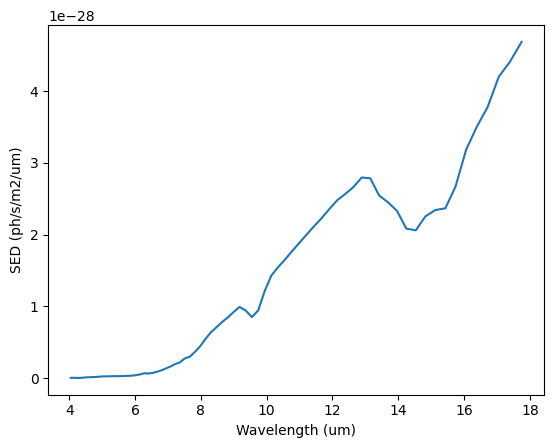

In [136]:
from matplotlib import pyplot as plt
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.pipeline import Pipeline
from lifesimmc.lib.observation import LIFEReferenceObservation
from lifesimmc.lib.instrument import LIFEReferenceDesign, InstrumentalNoise
from phringe.core.entities.scene import Scene

# Create scene and add planet
scene = Scene()
scene.add_source(earth_twin)

# Create instrument and observation
inst = LIFEReferenceDesign(instrumental_noise=InstrumentalNoise.NONE)
obs = LIFEReferenceObservation(
    total_integration_time='10 d',
    detector_integration_time='0.05 d',
    optimized_star_separation='0.1 arcsec'
)

# Create pipeline and add setup module
pipeline = Pipeline()
module = SetupModule(
    n_setup_out='setup',
    n_planet_params_out='params_init',
    instrument=inst,
    observation=obs,
    scene=scene
)
pipeline.add_module(module)

# Run pipeline
pipeline.run()

# Get planet parameter resource
params_init = pipeline.get_resource('params_init')

# Get SED and wavelengths and plot them
sed = params_init.params[0].sed / 10e6  # Convert to right units
wavelengths = params_init.params[0].sed_wavelength_bin_centers * 1e6  # Convert to um

plt.plot(wavelengths, sed)
plt.xlabel('Wavelength (um)')
plt.ylabel('SED (ph/s/m2/um)')
plt.show()

Loading configuration...
Done


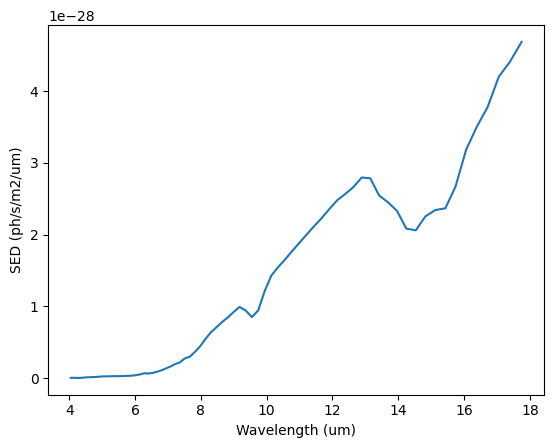

In [138]:
from matplotlib import pyplot as plt
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.pipeline import Pipeline
from lifesimmc.lib.observation import LIFEReferenceObservation
from lifesimmc.lib.instrument import LIFEReferenceDesign, InstrumentalNoise
from phringe.core.entities.scene import Scene

# Create scene and add planet
scene = Scene()
scene.add_source(earth_twin)

# Create instrument and observation
inst = LIFEReferenceDesign()
obs = LIFEReferenceObservation(
    total_integration_time='10 d',
    detector_integration_time='0.05 d',
    optimized_star_separation='0.1 arcsec'
)

# Create pipeline and add setup module
pipeline = Pipeline()
module = SetupModule(
    n_setup_out='setup',
    n_planet_params_out='params_init',
    instrument=inst,
    observation=obs,
    scene=scene
)
pipeline.add_module(module)

# Run pipeline
pipeline.run()

# Get planet parameter resource
params_init = pipeline.get_resource('params_init')

# Get SED and wavelengths and plot them
sed = params_init.params[0].sed / 10e6  # Convert to right units
wavelengths = params_init.params[0].sed_wavelength_bin_centers * 1e6  # Convert to um

plt.plot(wavelengths, sed)
plt.xlabel('Wavelength (um)')
plt.ylabel('SED (ph/s/m2/um)')
plt.show()